In [1]:
from sklearn.datasets import load_iris
from pprint import pprint
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
X,y=load_iris(return_X_y=True)

In [3]:
data=np.hstack((X,y.reshape(-1,1)))

In [117]:
data_train, data_test=train_test_split(data,test_size=20,random_state=1)

# Help Function

In [5]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [74]:
# def classify_data(data):
    
#     label_column = data[:, -1]
#     unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

#     index = counts_unique_classes.argmax()
#     classification = unique_classes[index]
    
#     return int(classification)

In [113]:
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = int(unique_classes[index])
    
    return leaf

In [52]:
def determine_type_of_feature(dat):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in range(dat.shape[1]-1):
        unique_values = np.unique(dat[:,feature])
        example_value = unique_values[0]

        if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
            feature_types.append("categorical")
        else:
            feature_types.append("continuous")
    return feature_types

In [67]:
# def get_potential_splits(data):
    
#     potential_splits = {}
#     _, n_columns = data.shape
#     for column_index in range(n_columns - 1):        # excluding the last column which is the label
#         potential_splits[column_index] = np.empty(0)
#         values = data[:, column_index]
#         unique_values = np.unique(values)
#         type_of_feature = FEATURE_TYPES[column_index]
#         if type_of_feature == "continuous":
#             potential_split = (unique_values[1:]+unique_values[0:-1])/2
#             potential_splits[column_index]=np.append(potential_splits[column_index],potential_split)
#         elif len(unique_values) > 1:
#             potential_splits[column_index] = unique_values
#     return potential_splits

In [68]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [26]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [80]:
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [9]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [76]:
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [77]:
def determine_best_split(data, potential_splits, ml_task):
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            # classification
            else:
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)
            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    return best_split_column, best_split_value

# Decision Tree Algorithm

In [123]:
def decision_tree_algorithm(dat, ml_task, counter=0, min_samples=2, max_depth=4):
    # data preparations
    data=dat         
    if counter == 0:
        global COLUMN_HEADERS,FEATURE_TYPES
        COLUMN_HEADERS = load_iris().feature_names
        FEATURE_TYPES = determine_type_of_feature(dat)
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1
        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        # instantiate sub-tree
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(split_column, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(split_column, split_value)
        # instantiate sub-tree
        sub_tree = {question: []}
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below,ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above,ml_task, counter, min_samples, max_depth)
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [177]:
tree=decision_tree_algorithm(data_train,ml_task='classification')
pprint(tree)

{'3 <= 0.6': [0,
              {'3 <= 1.7': [{'2 <= 4.9': [{'3 <= 1.6': [1, 2]},
                                          {'3 <= 1.5': [2, 1]}]},
                            {'2 <= 4.8': [{'1 <= 3.0': [2, 1]}, 2]}]}]}


In [160]:
def make_classifier(tree,dat):
    question=list(tree.keys())[0]
    col,comparison_operator,value=question.split()
    if comparison_operator == "<=":  # feature is continuous
        if dat[int(col)] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(dat[int(col)]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    if not isinstance(answer,dict):
        return answer
    else:
        return make_classifier(answer,dat)

In [64]:
def calculate_accuracy(dat, tree):
    result=[make_classifier(tree,i) for i in dat]
    accuracy=accuracy_score(result,dat[:,-1])
    return accuracy

In [180]:
for i in range(20):
    test=np.random.choice(np.arange(150),20)
    print(calculate_accuracy(data[test],tree))

1.0
1.0
1.0
1.0
0.95
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.95
1.0
1.0
1.0
0.95
1.0


In [144]:
calculate_accuracy(data,tree)

0.9933333333333333

In [162]:
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[int(feature_name)] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[int(feature_name)]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [163]:
def calculate_r_squared(data, tree):    
    labels = data[:,-1]
    mean = labels.mean()
    predictions = [predict_example(tree,i) for i in data]
    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot
    
    return r_squared

# Post Prunning

In [184]:
def filter_data(data, question):
    col, _, value = question.split()
    data_yes = data[data[:,int(col)] <= float(value)]
    data_no  = data[data[:,int(col)] >  float(value)]
    return data_yes, data_no

In [213]:
def pruning_result(tree, ml_task, train_data, test_data):
    leaf = create_leaf(train_data, ml_task)
    if ml_task == "regression":
        # mean squared error
        errors_leaf = np.sum((test_data[:,-1] - leaf)**2)
        result_classification = np.array([make_classifier(tree,i) for i in test_data])
        errors_decision_node = np.sum((test_data[:,-1] - result_classification)**2)
    else:
        # number of errors
        errors_leaf = np.sum(test_data[:,-1] != leaf)
        result_classification = np.array([make_classifier(tree,i) for i in test_data])
        errors_decision_node = np.sum(test_data[:,-1] != result_classification)
        
    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [211]:
def post_pruning(tree, ml_task, train_data, test_data):
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]
    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree,ml_task, train_data, test_data)
    # recursive part
    else:
        data_train_yes, data_train_no = filter_data(train_data, question)
        data_test_yes, data_test_no = filter_data(test_data, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer,ml_task, data_train_yes, data_test_yes)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer,ml_task, data_train_no, data_test_no)
            
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree,ml_task, train_data, test_data)

In [182]:
tree=decision_tree_algorithm(data_train,ml_task='classification',max_depth=10)
pprint(tree)

{'3 <= 0.6': [0,
              {'3 <= 1.7': [{'2 <= 4.9': [{'3 <= 1.6': [1, 2]},
                                          {'3 <= 1.5': [2,
                                                        {'2 <= 5.1': [1,
                                                                      2]}]}]},
                            {'2 <= 4.8': [{'1 <= 3.0': [2, 1]}, 2]}]}]}


In [216]:
prunning_tree = post_pruning(tree,'classification', data_train, data_test)
prunning_tree

{'3 <= 0.6': [0, {'3 <= 1.7': [1, 2]}]}

In [217]:
calculate_accuracy(data,prunning_tree)

0.96

# Sklearn

In [225]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

In [230]:
clf=DecisionTreeClassifier(max_depth=3)
clf.fit(data_train[:,:-1],data_train[:,-1])

DecisionTreeClassifier(max_depth=3)

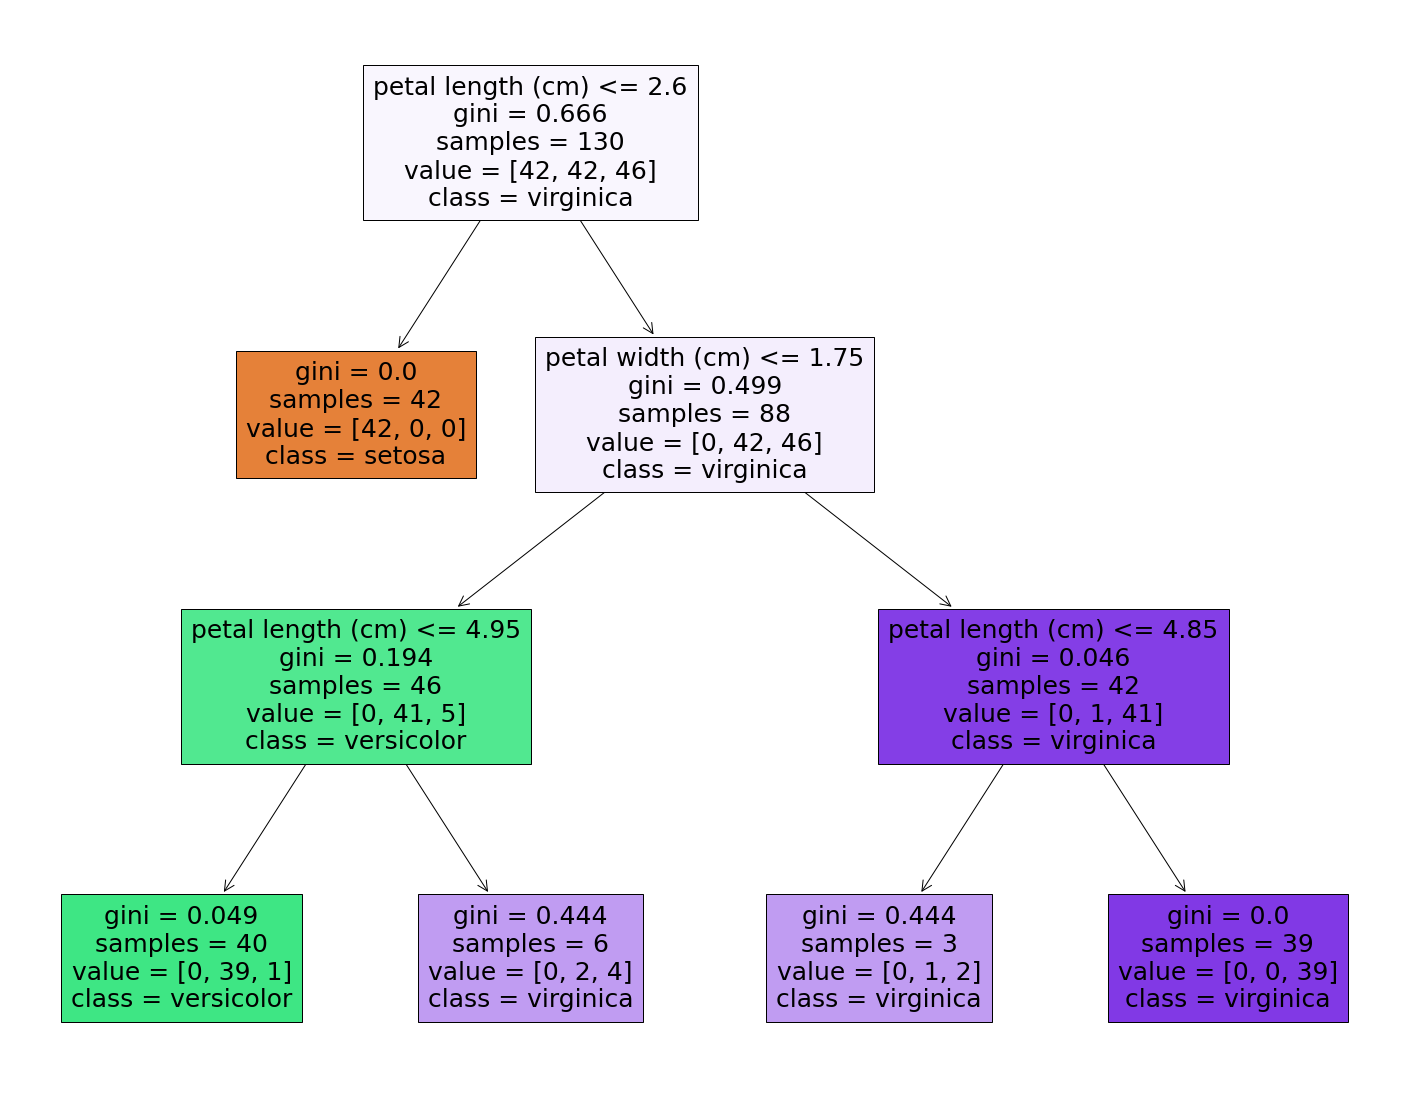

In [231]:
iris=load_iris()
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

In [234]:
clf.predict(data_test[:,:-1])

array([0., 1., 1., 0., 2., 1., 2., 0., 0., 2., 1., 0., 2., 1., 1., 0., 1.,
       1., 0., 0.])

In [235]:
accuracy_score(data_test[:,-1],clf.predict(data_test[:,:-1]))

1.0